## TODO:

- input z nazwą foldera ze zdjęciami (DONE)
- zamiast det_num, alfa i last_first, oficjalne nazwy zmiennych (DONE)
- akceptowanie wczytywania zdjęcia (*)
- zamienić polskie nazwy na angielskie (DONE)
- przy wybieraniu det_num, alfa i last_first wczytywać także do zmiennych -> https://github.com/jupyter-widgets/ipywidgets/issues/1947
- napisać funkcję do rysowania sinogramu która przyjmuje y jako parametr (DONE)
- napisać analogiczną funkę do sinogramtoResultImage (DONE)


In [33]:
from abc import abstractmethod

from bresenham import bresenham
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import os
from IPython.display import Image
import math

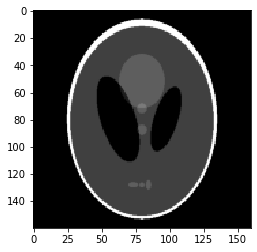

(160, 160)

In [34]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def readImage(filepath):
    return rgb2gray(mpimg.imread(filepath))

def showImage(img):
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.show()

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', multichannel=False)
showImage(image)
image.shape

In [35]:
sinogram = None

angleSpace = np.pi / 160 
angleRange = np.pi 
numberOfDetectors = 180

In [36]:
def circleCentre(image):
    coords = list(map(lambda x: x / 2, image.shape))
    radius = (coords[0] ** 2 + coords[1] ** 2) ** 0.5
    return {'x': coords[0], 'y': coords[1], 'r': radius}

circleCoords = circleCentre(image)
circleCoords

{'x': 80.0, 'y': 80.0, 'r': 113.13708498984761}

In [37]:
directoryName = input("Enter name of directory with images: ")
directoryName = directoryName + "/" 

radius = circleCoords['r'] 

Enter name of directory with images: ./tomograf-zdjecia


In [39]:
image_variable = widgets.Combobox(
    value= None,
    placeholder='Choose Someone',
    options=os.listdir(directoryName),
    description='File name:',
    ensure_option=True,
    disabled=False)

def imageFunction(x):
    image_variable.value = x
    display(Image(directoryName + str(image_variable.value)))
    
interact(imageFunction, x=os.listdir(directoryName))

interactive(children=(Dropdown(description='x', options=('CT_ScoutView-large.jpg', 'CT_ScoutView.jpg', 'Kolo.j…

<function __main__.imageFunction(x)>

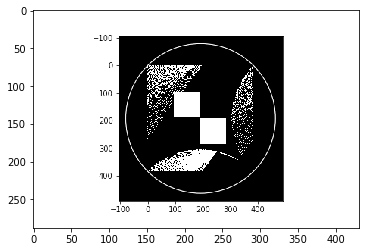

In [40]:
image = readImage(directoryName + str(image_variable.value))
showImage(image)

In [43]:
det_variable = widgets.IntSlider(
    min=90,
    max=720,
    step=90,
    description='Number of detector'
)

display(det_variable)

IntSlider(value=90, description='Number of detector', max=720, min=90, step=90)

In [44]:
numberOfDetectors = det_variable.value
numberOfDetectors

90

In [45]:
def getPosition(alpha):
    x = circleCoords['x'] + circleCoords['r'] * np.cos(alpha)
    y = circleCoords['y'] + circleCoords['r'] * np.sin(alpha)
    return [int(x), int(y)]

def readValue(emiPos, detPos):
    allPoints = list(bresenham(emiPos[0], emiPos[1], detPos[0], detPos[1]))
    brightness = 0
    pixelsNum = 0
    for point in allPoints:
        if 0 < point[0] < image.shape[0] and 0 < point[1] < image.shape[1]:
            pixelsNum += 1
            brightness += image[point[0]][point[1]]
    if pixelsNum > 0:
        val = brightness / pixelsNum
        return val
    else:
        return 0
    
positionForSin = np.zeros((int(2 * np.pi / angleSpace), numberOfDetectors, 2, 2)) 


def toSinogram(angleSpace, angleRange, numberOfDetectors):
    sin = np.zeros((int(2 * np.pi / angleSpace), numberOfDetectors))
    for emitterAngle, i in zip(np.arange(0, 2 * np.pi, angleSpace), range(int(2 * np.pi / angleSpace))):
        emitterPosition = getPosition(emitterAngle)
        for detectorAngle, j in zip(np.arange(emitterAngle + np.pi - angleRange / 2, emitterAngle + np.pi + angleRange / 2, angleRange / numberOfDetectors), range(numberOfDetectors)):
            detectorPosition = getPosition(detectorAngle)
            sin[i][j] = readValue(emitterPosition, detectorPosition)
            positionForSin[i][j] = [detectorPosition, emitterPosition]
            #drawLine(emitterPosition, detectorPosition)
    return sin, positionForSin


            
sinogram, positionForSin = toSinogram(angleSpace, angleRange, numberOfDetectors)

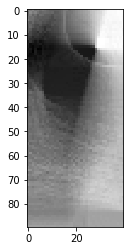

In [46]:
def imageAnimation(y):
    max_y = sinogram.shape[0]
    if y < max_y:
        tempSinogram = np.zeros((sinogram.shape[1],y))
        for y in range(y):
            for x in range(sinogram.shape[1]):
                tempSinogram[x][y] = int(255*sinogram[x][y])
    else:
        pass
    showImage(tempSinogram)
    
imageAnimation(40)

In [47]:
y = widgets.IntSlider(min=1, max=numberOfDetectors, description='y')
out = widgets.interactive_output(imageAnimation, {'y': y})
widgets.HBox([widgets.VBox([y]), out])

In [48]:
positionForSin[0][0]

array([[ 80., 193.],
       [193.,  80.]])

In [49]:
np.amax(sinogram)

0.9998999999999997

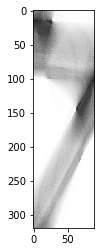

In [50]:
showImage(sinogram)

In [66]:
resultImage = np.zeros(image.shape)
countForPoints = np.zeros(image.shape)
resultStepByStep = [np.zeros(image.shape)]
countForPointsStepByStep = [np.zeros(image.shape)]

def normalizeStep(step):
    for x in range(len(countForPointsStepByStep[step])):
        for y in range(len(countForPointsStepByStep[step][x])):
            val = countForPointsStepByStep[step][x][y]
            if val[0] != 0:
                resultStepByStep[step][x][y] /= val
                
    return resultStepByStep


In [67]:
def addLineToResult(emiPos, detPos, value):
    
    allPoints = list(bresenham(int(emiPos[0]), int(emiPos[1]), int(detPos[0]), int(detPos[1])))
    for point in allPoints:
        if 0 <= point[0] < image.shape[0] and 0 <= point[1] < image.shape[1]:
            countForPoints[point[0]][point[1]] += 1
            resultImage[point[0]][point[1]] += value
      
    return countForPoints, resultImage


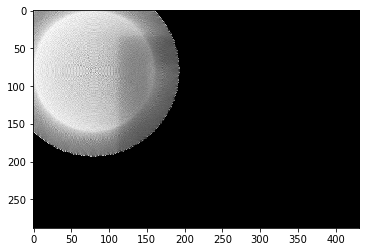

In [68]:
def sinogramToResultImage(angleSpace, angleRange): 
    for i in range(sinogram.shape[0]):
        for j in range(sinogram.shape[1]):
            emitterPosition = positionForSin[i][j][1]
            detectorPosition = positionForSin[i][j][0]
            countForPoints, resultImage = addLineToResult(emitterPosition, detectorPosition, sinogram[i][j])
                      
sinogramToResultImage(angleSpace, angleRange)
showImage(resultImage)


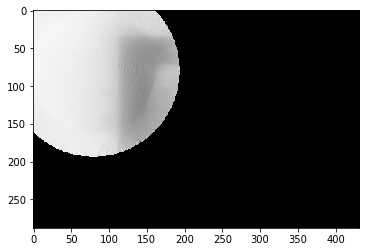

In [69]:
def divideByCountForPoints(resultImage):
    for i in range(resultImage.shape[0]):
        for j in range(resultImage.shape[1]):
            if countForPoints[i][j] != 0:
                resultImage[i][j] /= countForPoints[i][j]
            else:
                resultImage[i][j] = 0
                
    return resultImage
                
resultImage = divideByCountForPoints(resultImage)
showImage(resultImage)

In [70]:
#imageAnimation(resultImage, 70)
def resultImageAnimation(z):
    max_y = resultImage.shape[0]
    if z < max_y:
        tempSinogram = np.zeros((resultImage.shape[1],z))
        for y in range(z):
            for x in range(resultImage.shape[1]):
                tempSinogram[x][y] = int(255*resultImage[x][y])
    else:
        pass
    showImage(tempSinogram)

In [71]:
z = widgets.IntSlider(min=1, max=resultImage.shape[0] - 1, description='z')
out = widgets.interactive_output(resultImageAnimation, {'z': z})
widgets.HBox([widgets.VBox([z]), out])


# Dla sprawdzenia - przy użyciu gotowych funkcji

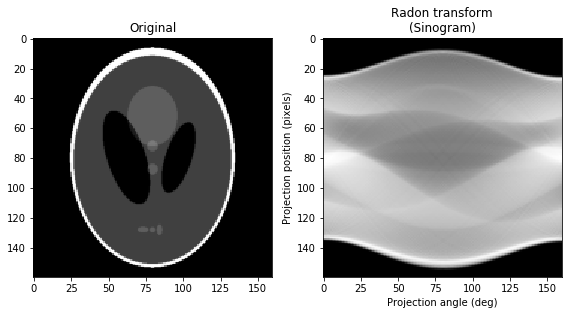

In [72]:
image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', multichannel=False)
#image = readImage('tomograf-zdjecia/Kolo.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=True)
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
"""ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')"""
ax2.imshow(sinogram, cmap=plt.cm.Greys_r)

fig.tight_layout()
plt.show()